# Data Preprocessing

In [ ]:
!pip install pyESN

In [163]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterSampler
import matplotlib.pyplot as plt
from pyESN import ESN

data = pd.read_csv("./DB/apple_stock.csv")



In [165]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2.475000e+03
mean,76.004968,76.845661,75.213720,76.064199,74.097124,1.380565e+08
std,54.739063,55.389713,54.134658,54.787600,55.248195,8.399674e+07
min,17.684999,17.911785,17.626785,17.849285,15.648315,3.145820e+07
25%,29.592500,29.841249,29.371249,29.707500,27.131330,8.300500e+07
50%,47.507500,47.967499,47.267502,47.599998,45.507229,1.134760e+08
75%,132.145004,133.680000,130.495003,132.029999,130.403320,1.682138e+08
max,196.240005,198.229996,195.279999,196.449997,195.926956,1.065523e+09


In [167]:
print(data.shape)

(2475, 7)


In [169]:
# Check for missing values
print(data.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


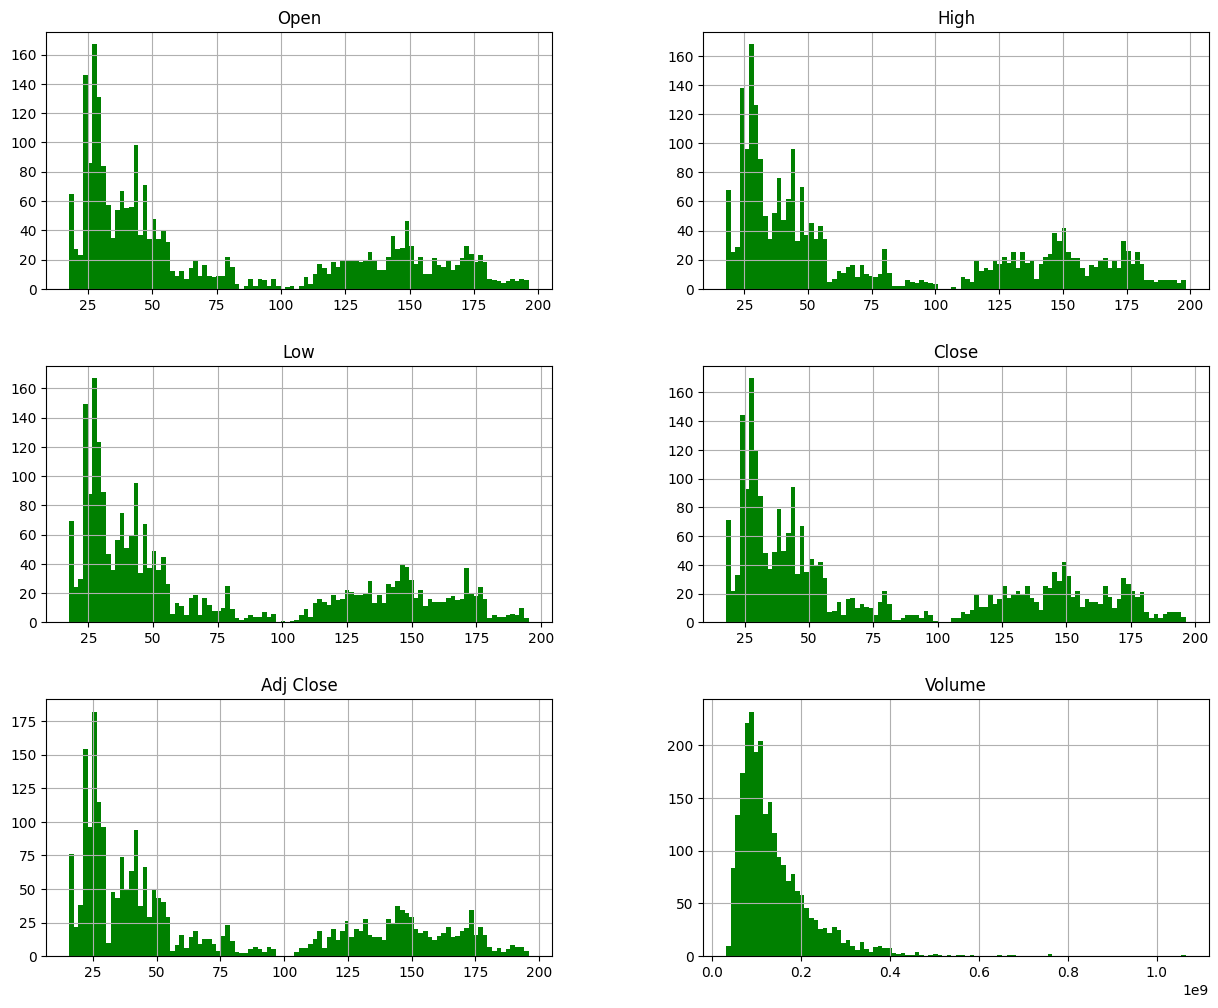

In [171]:
data.hist(bins=100, figsize=(15, 12), color='green')
plt.show()

In [172]:
#Normalization 
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

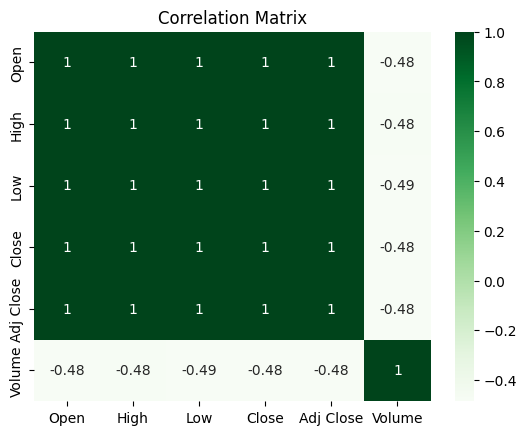

In [175]:
# Correlation matrix
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Greens')
plt.title('Correlation Matrix')
plt.show()

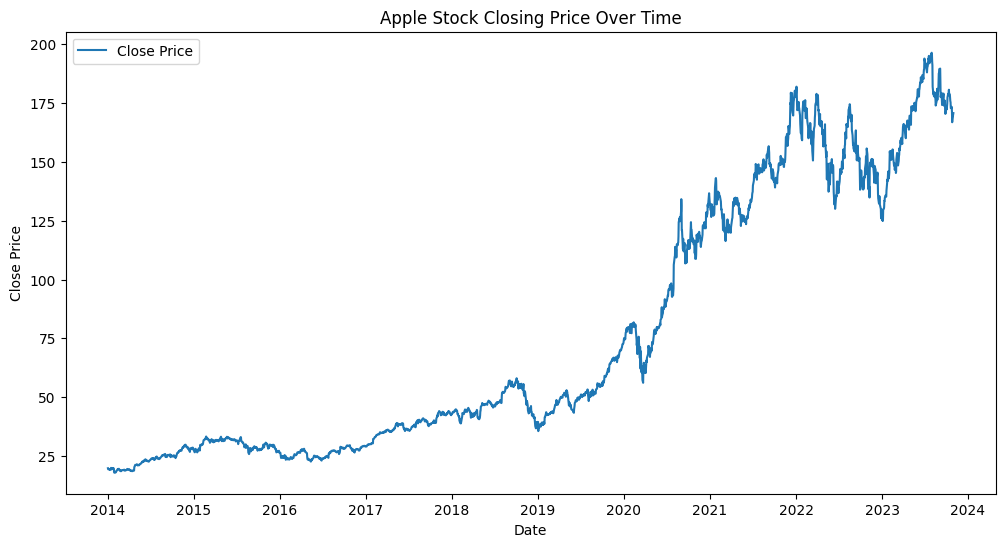

In [177]:
# Visualize the closing price
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Close Price')
plt.title('Apple Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [179]:
print(data.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [181]:
# Drop unnecessary columns
data = data.drop(['High', 'Low', 'Volume', 'Open', 'Adj Close'], axis=1)

In [183]:
data.head()

,Close
Date,
2014-01-02,19.754642
2014-01-03,19.320715
2014-01-06,19.426071
2014-01-07,19.287144
2014-01-08,19.409286


In [232]:
# Split data into train, validation, and test
train_size = int(len(scaled_data) * 0.7)
val_size = int(len(scaled_data) * 0.2)

train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size + val_size]
test_data = scaled_data[train_size + val_size:]

In [187]:
# 2. Define Hyperparameter Search Space
param_dist = {
    'n_reservoir': np.arange(100, 1000, 100),
    'sparsity': np.linspace(0.1, 0.5, 5),
    'spectral_radius': np.linspace(0.5, 1.5, 5),
    'noise': np.linspace(0.0001, 0.01, 5),
    'random_state': [42]
}

n_iter_search = 20  # Number of random search iterations

# 3. Random Search for Best Hyperparameters
best_model = None
best_score = float('inf')

for params in ParameterSampler(param_dist, n_iter=n_iter_search):
    esn = ESN(n_inputs=5,
              n_outputs=1,
              n_reservoir=params['n_reservoir'],
              sparsity=params['sparsity'],
              spectral_radius=params['spectral_radius'],
              noise=params['noise'],
              random_state=params['random_state'])

    # Train ESN
    predicted_train = esn.fit(train_data[:-1], train_data[1:, 3:4])

    # Validate ESN
    predicted_val = esn.predict(val_data[:-1])
    predicted_val_inv = scaler.inverse_transform(np.hstack([val_data[1:, :3], predicted_val, val_data[1:, 4:]]))[:, 3]
    actual_val_inv = scaler.inverse_transform(val_data[1:])[:, 3]

    # Calculate RMSE for validation
    val_rmse = np.sqrt(mean_squared_error(actual_val_inv, predicted_val_inv))

    # Store the best model
    if val_rmse < best_score:
        best_score = val_rmse
        best_model = esn
        best_params = params



In [188]:
# Print the best hyperparameters
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'spectral_radius': np.float64(1.5), 'sparsity': np.float64(0.30000000000000004), 'random_state': 42, 'noise': np.float64(0.007525000000000001), 'n_reservoir': np.int64(400)}


In [201]:
 #5. Evaluate Best Model on Test Data
predicted_test = best_model.predict(test_data[:-1])
predicted_test_inv = scaler.inverse_transform(np.hstack([test_data[1:, :3], predicted_test, test_data[1:, 4:]]))[:, 3]
actual_test_inv = scaler.inverse_transform(test_data[1:])[:, 3]

predicted_train_inv = scaler.inverse_transform(np.hstack([train_data[1:, :3], predicted_train, train_data[1:, 4:]]))[:, 3]
actual_train_inv = scaler.inverse_transform(train_data[1:])[:, 3]


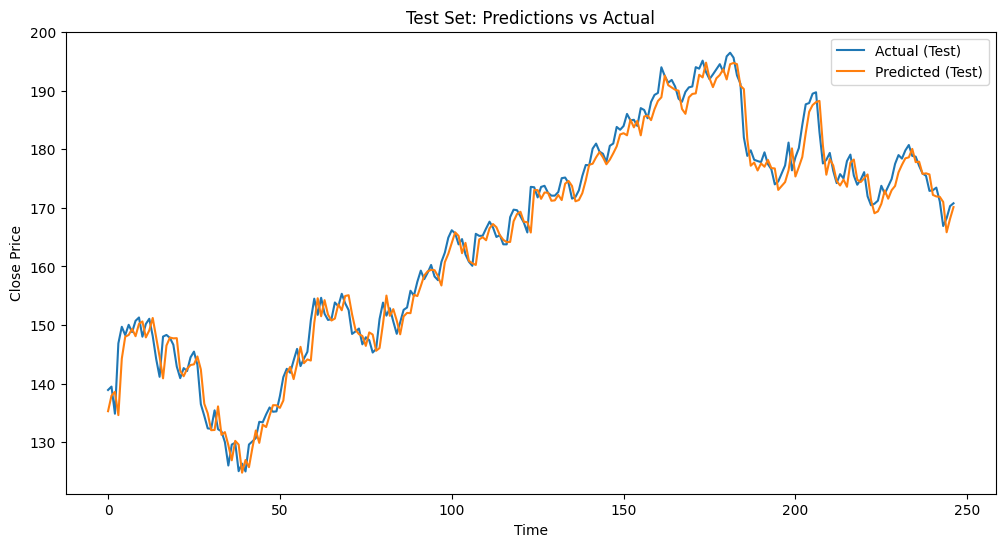

In [203]:
# 5. Visualization of Results
plt.figure(figsize=(12, 6))
plt.plot(actual_test_inv, label='Actual (Test)')
plt.plot(predicted_test_inv, label='Predicted (Test)')
plt.title('Test Set: Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [205]:
# Calculate Performance Metrics
train_rmse = np.sqrt(mean_squared_error(actual_train_inv, predicted_train_inv))
val_rmse = np.sqrt(mean_squared_error(actual_val_inv, predicted_val_inv))
test_rmse = np.sqrt(mean_squared_error(actual_test_inv, predicted_test_inv))

train_mae = mean_absolute_error(actual_train_inv, predicted_train_inv)
val_mae = mean_absolute_error(actual_val_inv, predicted_val_inv)
test_mae = mean_absolute_error(actual_test_inv, predicted_test_inv)

train_r2 = r2_score(actual_train_inv, predicted_train_inv)
val_r2 = r2_score(actual_val_inv, predicted_val_inv)
test_r2 = r2_score(actual_test_inv, predicted_test_inv)

Train RMSE: 0.9567, Validation RMSE: 4.0009, Test RMSE: 2.5937
Train MAE: 0.5788, Validation MAE: 3.1701, Test MAE: 2.0076
Train R^2: 0.9982, Validation R^2: 0.9411, Test R^2: 0.9804


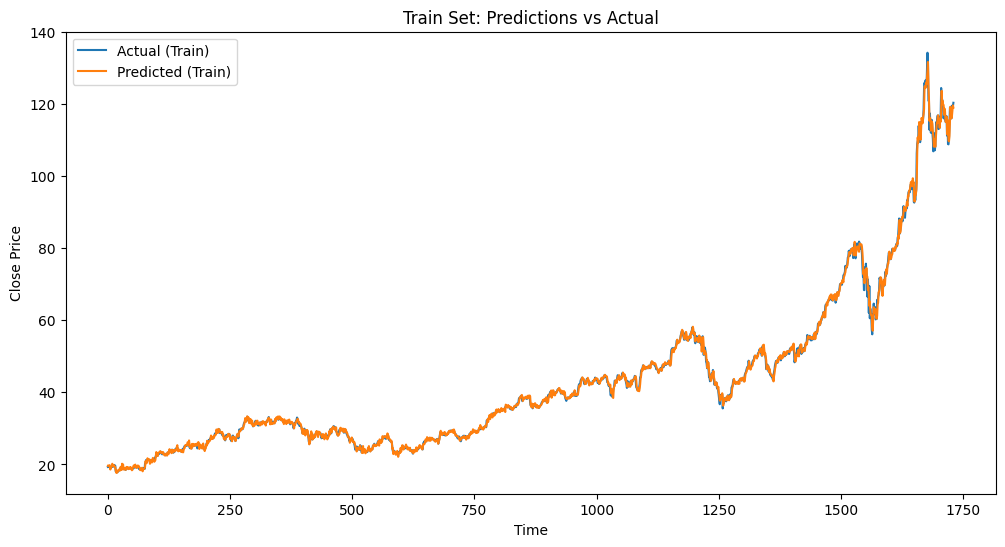

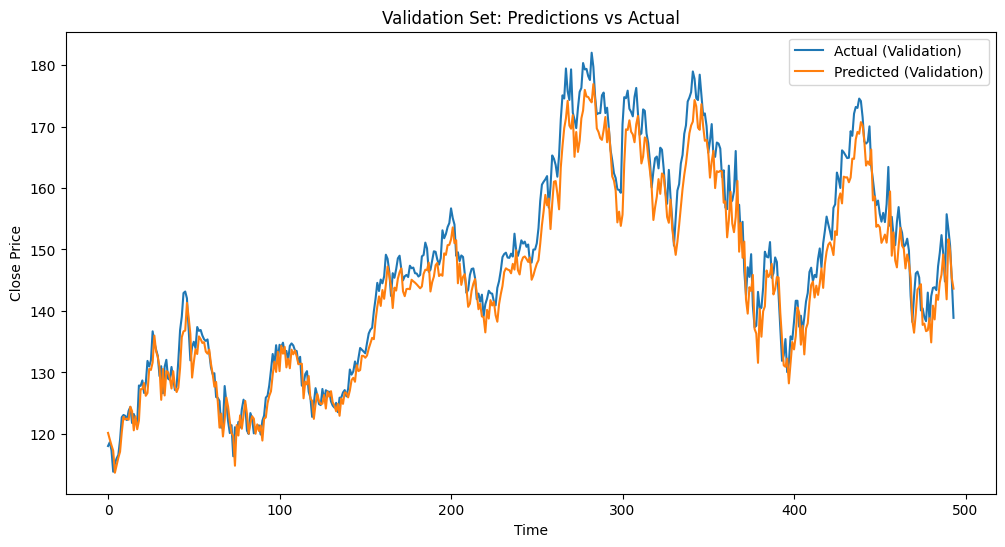

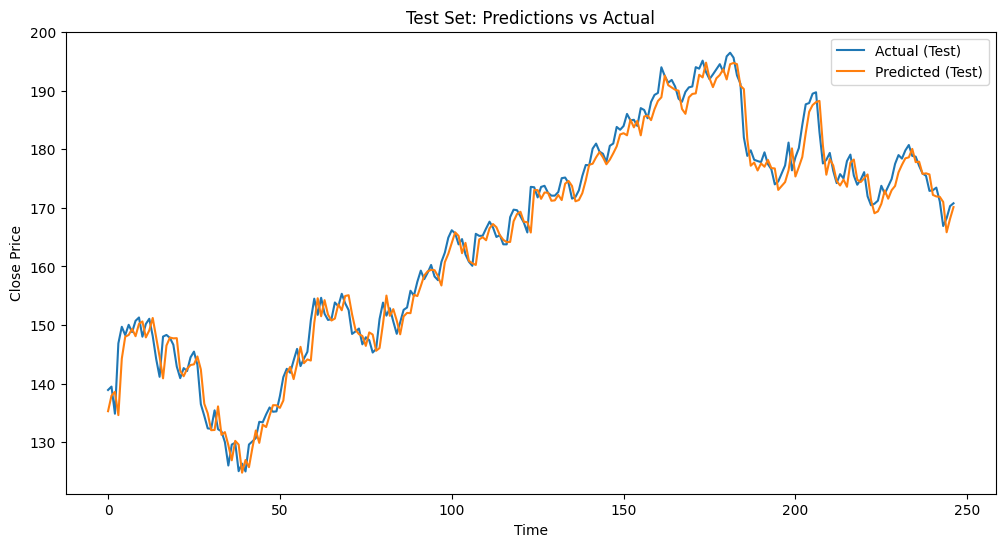

In [207]:
# Print Metrics
print(f"Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}, Validation MAE: {val_mae:.4f}, Test MAE: {test_mae:.4f}")
print(f"Train R^2: {train_r2:.4f}, Validation R^2: {val_r2:.4f}, Test R^2: {test_r2:.4f}")

# 6. Visualization of Train, Validation, and Test Results
plt.figure(figsize=(12, 6))
plt.plot(actual_train_inv, label='Actual (Train)')
plt.plot(predicted_train_inv, label='Predicted (Train)')
plt.title('Train Set: Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(actual_val_inv, label='Actual (Validation)')
plt.plot(predicted_val_inv, label='Predicted (Validation)')
plt.title('Validation Set: Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(actual_test_inv, label='Actual (Test)')
plt.plot(predicted_test_inv, label='Predicted (Test)')
plt.title('Test Set: Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()